## Marine Litter Detection with YOLO

### Why is Marine Litter a Problem? 
Marine debris can kill and injure marine wildlife through ingestion and entanglement, disperse invasive species, endanger human health, cause damage to shipping vessels, and hurt businesses and tourism by polluting our beaches and coastline.

### The Project
Our team aims to build a completely autonomous aquatic surface vehicle that will be capable of collecting floating trash in water bodies automatically, without needing to be remotely controlled. The following notebook explores how YOLO object detection algorithm can be used for developing a vision based navigation algorithm for the bot for autonomous path planning. It will be a basic prototype level algorithm that can be used in controlled environment. As it is still in its early stages, it is only capable of detecting bottles as of now. We aim to build a robust algorithm trained on customized image dataset of marine litter in the future.

In [16]:
#import necessary libraries
import os
import time
import cv2
import numpy as np
from model.yolo_model import YOLO
import matplotlib.pyplot as plt

We’ll be using YOLOv3, particularly trained on the COCO dataset.

The COCO dataset consists of 80 labels, including, but not limited to:

- People
- Bicycles
- Cars and trucks
- Airplanes
- Stop signs and fire hydrants
- Animals, including cats, dogs, birds, horses, cows, and sheep, to name a few

…and much more!

In [17]:
def get_classes(file):
    """Get classes name.

    # Argument:
        file: classes name for database.

    # Returns
        class_names: List, classes name.

    """
    with open(file) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]

    return class_names

In [18]:
#importing weights of pre-trained deep learning YOLO network
yolo = YOLO(0.6, 0.5)
file = 'data/coco_classes.txt'
#make a list of all the identifiable classes 
all_classes = get_classes(file)

C:\Users\admin\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [455]:
img_address = 'Marine_Litter_1.png'

In [456]:
#import sample image
img = cv2.imread(img_address)

In [457]:
img.shape

(1133, 1280, 3)

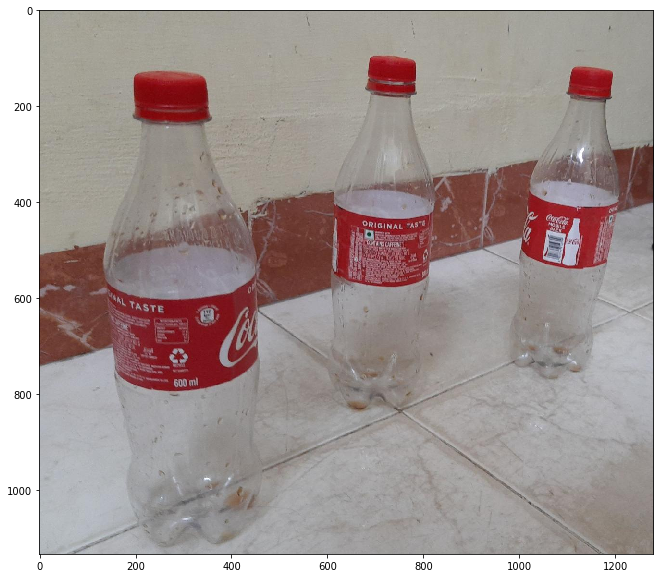

In [458]:
img = cv2.imread(img_address)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [459]:
#resizing image according to the size of the input layer of the neural network
image = cv2.resize(img, (416, 416),
                       interpolation=cv2.INTER_CUBIC)
shape_init = image.shape
image = np.array(image, dtype='float32')
image /= 255.
image = np.expand_dims(image, axis=0)
shape_final = image.shape

In [460]:
print("Initial Shape after Resizing : ",shape_init,"\t\t Final Shape after Expanding Dimensions : ",shape_final)

Initial Shape after Resizing :  (416, 416, 3) 		 Final Shape after Expanding Dimensions :  (1, 416, 416, 3)


## Object Detection and Visualization

### Prediction
A pretrained YOLO algorithm isused on this new image. The prediction output consists of these three parameter for each of the object detected:- 

- Scores : Represents how likely the object will be present in the volume
- Boxes : Returns the (x1, y1, x2, y2) coordinates for the detected objects
- Classes : Returns class of the identified object

For the objective of the project, that is to detect marine litter, only the class - *Bottle* will be considered.
All the other detected classes will be ignored.

In [461]:
#prediction task
boxes, classes, scores = yolo.predict(image, img.shape)

In [462]:
img = cv2.imread(img_address)
image_draw = img[:]

In [463]:
global cX, cY
area = []
cl_list = []
cl_max = None

# iterate through all the instances of all the detected objects
for box, score, cl in zip(boxes, scores, classes):
    x, y, w, h = box
    
    # computing coordinates of the grid enclosing the detected object
    top = max(0, np.floor(x + 0.5).astype(int))
    left = max(0, np.floor(y + 0.5).astype(int))
    right = min(image_draw.shape[1], np.floor(x + w + 0.5).astype(int))
    bottom = min(image_draw.shape[0], np.floor(y + h + 0.5).astype(int))
    
    # check if this particular object has been identified as a bottle
    if all_classes[cl] == 'bottle':
        # in the case of a bottle, area of the bounding box is calculated 
        area_temp = (top - right)*(left - bottom)
        area.append(area_temp)
        cl_list.append(cl)  

        # Number of bottles detected == Number of Areas computed
print("Number of bottles detected are : ", len(area))

Number of bottles detected are :  3


In [464]:
print("Areas Computed are : ",area)

Areas Computed are :  [155817, 339022, 164736]


In [465]:
if len(area) != 0:  
    cl_max = np.argmax(area) # index of the object instance having largest bounding box area

print(cl_max)

1


### Drawing Bounding Boxes around Bottles

In this section, coordinates for the bounding boxes will be calculated and rectangles will be drawn around all the detected bottles. 

In [466]:
for box, score, cl in zip(boxes, scores, classes):
    x, y, w, h = box

    top = max(0, np.floor(x + 0.5).astype(int))
    left = max(0, np.floor(y + 0.5).astype(int))
    right = min(image_draw.shape[1], np.floor(x + w + 0.5).astype(int))
    bottom = min(image_draw.shape[0], np.floor(y + h + 0.5).astype(int))

    if all_classes[cl] == 'bottle':
        
            cv2.rectangle(image_draw, (top, left), (right, bottom), (0, 0, 0), 2)
            cv2.circle(image_draw,center = (int((top+right)/2),int((left+bottom)/2)),radius = 5,color=(255,0,0),thickness = -1)
            cv2.putText(image_draw, '{0}'.format(all_classes[cl]),
                        (top, left - 6),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 0, 255), 2,
                        cv2.LINE_AA)  

    print('class: {0}, score: {1:.2f}'.format(all_classes[cl], score))
    print('box coordinate x,y,w,h: {0}'.format(box))

class: diningtable, score: 0.82
box coordinate x,y,w,h: [  85.33332825  244.1254684  1151.3394165   810.12036234]
class: bottle, score: 1.00
box coordinate x,y,w,h: [617.41172791  65.30323434 198.62163544 782.85354924]
class: bottle, score: 0.99
box coordinate x,y,w,h: [ 135.2243042    83.96102634  336.6437149  1005.91796213]
class: bottle, score: 0.98
box coordinate x,y,w,h: [975.59158325 114.33272731 264.42695618 623.78859669]


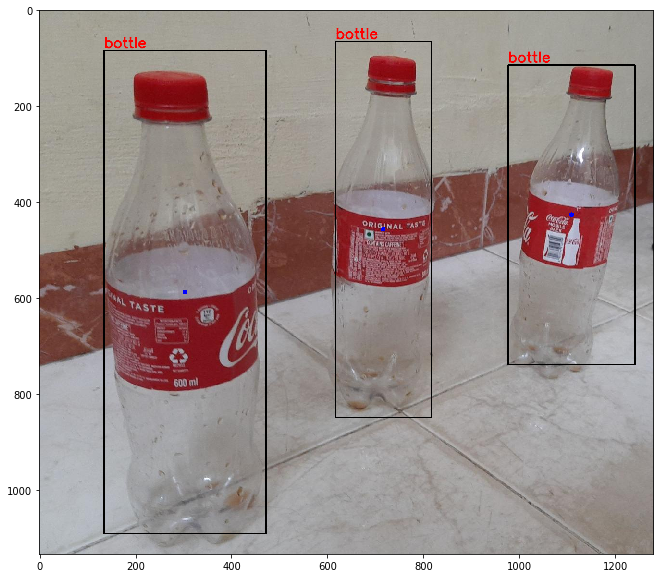

In [467]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))

In [468]:
img = cv2.imread(img_address)
image_draw_final = img[:]

## Path Planning

#### Deciding Priority of Bottles

Having successfully detected all bottles in the image frame, the next step is to plan the path for the bot to effectively track and collect these objects. For doing that, a priority based method is employed. This method involves setting priority to each of the detected objects based upon their distance from the camera / bot. In the absence of RGBD cameras, an approximate hierarchy of the distances of each of the objects is devised with the help of the areas of their bounding boxes.

A rough description of the algorithm flow is :
1. Detect bottles and draw bounding boxes around each of the objects.
2. Compute areas of each of the bounding boxes.
3. Bounding box with maximum area is identified.
4. The corresponding bottle object is declared to have the highest priority.
5. The bot will target reaching the high priority objects first

In [469]:
max_area_flag = 0
for box, score, cl in zip(boxes, scores, classes):
    x, y, w, h = box

    top = max(0, np.floor(x + 0.5).astype(int))
    left = max(0, np.floor(y + 0.5).astype(int))
    right = min(image_draw_final.shape[1], np.floor(x + w + 0.5).astype(int))
    bottom = min(image_draw_final.shape[0], np.floor(y + h + 0.5).astype(int))


    print(max_area_flag)
    if all_classes[cl] == 'bottle':
        if max_area_flag == cl_max:
            # identify object with largest area of bounding box
            cv2.rectangle(image_draw_final, (top, left), (right, bottom), (0, 0, 255), 2)
            cv2.circle(image_draw_final,center = (int((top+right)/2),int((left+bottom)/2)),radius = 5,color=(255,0,0),thickness = -1)
            cv2.putText(image_draw_final, '{} {} '.format('Closest Target',all_classes[cl]),
                        (top, left - 6),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 0, 255), 2,
                        cv2.LINE_AA)
            (cX,cY) = (int((top+right)/2),int((left+bottom)/2))

        else:
            cv2.rectangle(image_draw_final, (top, left), (right, bottom), (0, 0, 0), 2)
            cv2.circle(image_draw_final,center = (int((top+right)/2),int((left+bottom)/2)),radius = 5,color=(255,0,0),thickness = -1)
            cv2.putText(image_draw_final, '{0}'.format(all_classes[cl]),
                        (top, left - 6),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 0, 255), 2,
                        cv2.LINE_AA)  

        max_area_flag = max_area_flag + 1

    print('class: {0}, score: {1:.2f}'.format(all_classes[cl], score))
    print('box coordinate x,y,w,h: {0}'.format(box))

0
class: diningtable, score: 0.82
box coordinate x,y,w,h: [  85.33332825  244.1254684  1151.3394165   810.12036234]
0
class: bottle, score: 1.00
box coordinate x,y,w,h: [617.41172791  65.30323434 198.62163544 782.85354924]
1
class: bottle, score: 0.99
box coordinate x,y,w,h: [ 135.2243042    83.96102634  336.6437149  1005.91796213]
2
class: bottle, score: 0.98
box coordinate x,y,w,h: [975.59158325 114.33272731 264.42695618 623.78859669]


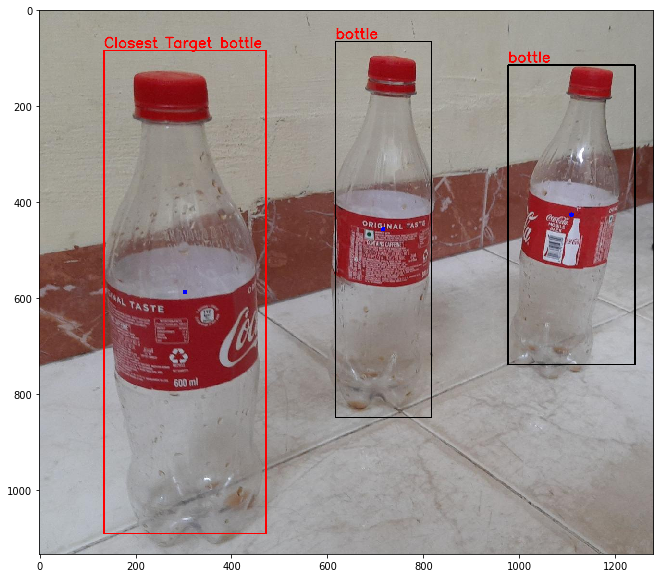

In [470]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(image_draw_final, cv2.COLOR_BGR2RGB))

## Movement Control

Once the high priority object is identified, the bot needs to controlled in such a way that it reaches the object. The algorithm devised for the same is as follows:

1. Inspect the position of the object with respect to the image frame
2. For doing so, divide the the image frame into 3 sections

    - Section A : Centre : Constitutes of the central 30% of the frame
    - Section B : Left : Left to the central section
    - Section C : Right : Right to the central section
    
    
3. The horizontal position coordinate of the high priority object should be considered and and be used in deciding which of the sections the coordinates are lying in.

In [471]:
img = cv2.imread(img_address)
image_draw_final_nav = img[:]

In [472]:
right_border = int((image_draw_final_nav.shape[1]/2) + 0.15*image_draw_final_nav.shape[1])
left_border = int((image_draw_final_nav.shape[1]/2) - 0.15*image_draw_final_nav.shape[1])

In [473]:
top = left_border
left = image_draw_final_nav.shape[0] 
right = right_border 
bottom = 0

In [474]:
(top,right)

(448, 832)

In [475]:
# draw and mark boundaires of the central section
cv2.rectangle(image_draw_final_nav, (top, left), (right, bottom), (100, 255, 0), 5)

# label each of the sections
cv2.putText(image_draw_final_nav, 'Section A',
                        (int(left_border/20),int(image_draw_final_nav.shape[0]-50)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1.5, (255, 0, 0), 2,
                        cv2.LINE_AA)  

cv2.putText(image_draw_final_nav, 'Section B',
                        (int(left_border/20 + left_border),int(image_draw_final_nav.shape[0]-50)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1.5, (255, 0, 0), 2,
                        cv2.LINE_AA) 

cv2.putText(image_draw_final_nav, 'Section C',
                        (int(left_border/20 + 2*left_border),int(image_draw_final_nav.shape[0]-50)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1.5, (255, 0, 0), 2,
                        cv2.LINE_AA) 

print()

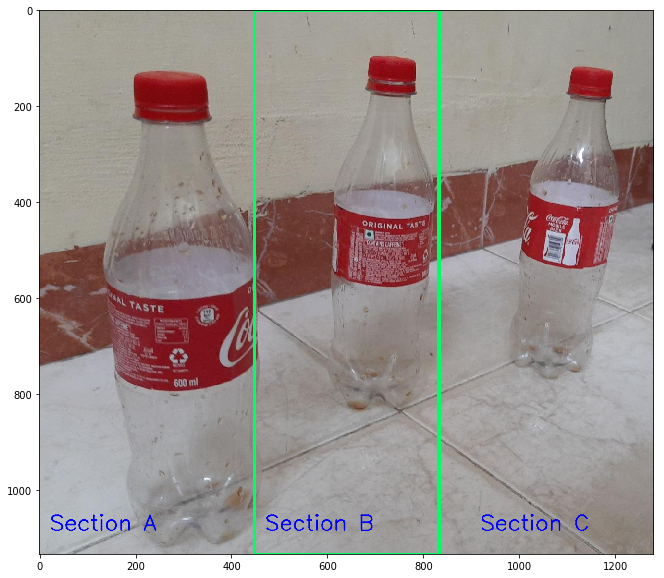

In [476]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(image_draw_final_nav, cv2.COLOR_BGR2RGB))

## Control Instructions

Once the section that the object belongs to is identified, the following instructions should be given to the bot:

- Section A : Steer the camera / bot to the left, so that it faces the bottle and propels forward
- Section B : Camera / bot is already facing the bottle, go straight ahead
- Section C : Steer the camera / bot to the right, so that it faces the bottle and propels forward

In [477]:
if len(area) != 0:

    if cX > (image_draw_final_nav.shape[1]/2) + 0.15*image_draw_final_nav.shape[1]:
        cv2.putText(image_draw_final, 'Steer Right',
                        (int(image_draw_final_nav.shape[1]/2),int(image_draw_final_nav.shape[0]/25)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        5, (255, 0, 0), 5,
                        cv2.LINE_AA)  

    elif cX < (image_draw_final_nav.shape[1]/2) - 0.15*image_draw_final_nav.shape[1]:
        cv2.putText(image_draw_final, 'Steer Left',
                        (int(image_draw_final_nav.shape[1]/2),int(image_draw_final_nav.shape[0]/25)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1.2, (255, 0, 0), 5,
                        cv2.LINE_AA) 
        #print('Rotate Laptop to the Left')

    else:
        cv2.putText(image_draw_final, 'Head Straight',
                        (int(image_draw_final_nav.shape[1]/40),int(image_draw_final_nav.shape[0]/10)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        2.0, (255, 0, 0), 5,
                        cv2.LINE_AA) 
        #print('Head Straight')

else:
    cv2.putText(image_draw_final, 'No bottle detected',
                        (int(image_draw_final_nav.shape[1]/2),int(image_draw_final_nav.shape[0]/2)-100),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1.2, (255, 0, 0), 5,
                        cv2.LINE_AA) 
        #print('Head Straight')


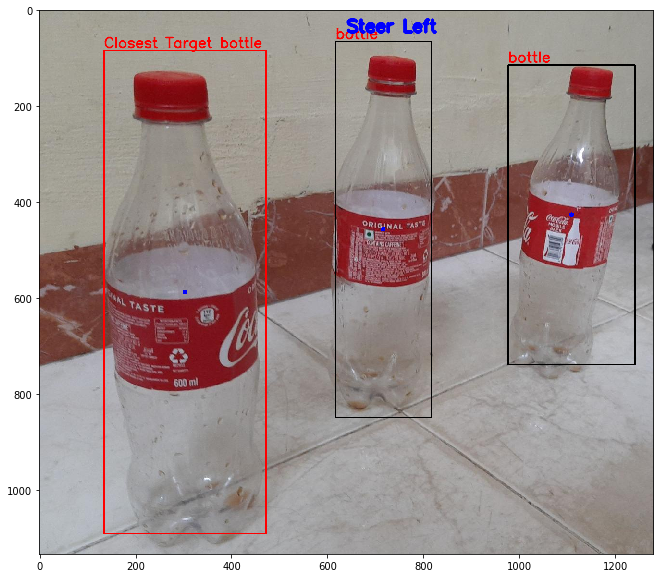

In [478]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(image_draw_final, cv2.COLOR_BGR2RGB))